In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv


# Abstract

The purpose of this notebook is to perform charecter recognition on TMNIST Alphabet (94 characters) dataset. We are using a simple CNN network to perform the charecter recognition.

MNIST style images of the following 94 alphabetic characters:

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\', ']', '^', '_', '`', '{', '|', '}', '~'}

# Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import re

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf 
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing and Reading Data

In [3]:
data = pd.read_csv("../input/tmnist-alphabet-94-characters/94_character_TMNIST.csv")
data.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Splitting the Labels

We're doing this so that it can classify predictions accurately and precisely.

In [4]:
# Get unique labels
unique_labels = list(data['labels'].unique())

# Regular expressions for different categories
uppercase_regex = re.compile(r"[A-Z]")
lowercase_regex = re.compile(r"[a-z]")
digits_regex = re.compile(r"[0-9]")
symbols_regex = re.compile(r"[\W]|[\_\,]")

# Extract categories from unique labels
uppercase_chars = uppercase_regex.findall(str(unique_labels))
lowercase_chars = lowercase_regex.findall(str(unique_labels))
digits_chars = digits_regex.findall(str(unique_labels))
symbols_chars = list(set(symbols_regex.findall(str(unique_labels))))
symbols_chars.pop(27)

# Assign group numbers to categories
group_num = 1
for category in (lowercase_chars, uppercase_chars, digits_chars, symbols_chars):
    data.loc[data['labels'].isin(category), 'group'] = group_num
    group_num += 1

In [5]:
# defining X and y for training
X = data.iloc[:, 2:-1].astype('float32') 
y  = data[['labels']] 

In [6]:
# Preparing the data to create dictionaries
unique_labels = y['labels'].unique()
numeric_values = list(range(len(unique_labels)))

# Creating dictionaries
label_to_value = dict(zip(unique_labels, numeric_values))
value_to_label = dict(zip(numeric_values, unique_labels))

In [7]:
# Mapping the Values
y['labels'].replace(label_to_value, inplace=True)

In [8]:
#Checking the mappings
print(label_to_value)

{'6': 0, 'D': 1, 'f': 2, '/': 3, 'F': 4, 'x': 5, 'J': 6, '8': 7, 'H': 8, 'k': 9, '@': 10, '1': 11, '=': 12, 'g': 13, ')': 14, '2': 15, 'd': 16, '^': 17, '3': 18, 't': 19, '#': 20, '.': 21, '4': 22, 'o': 23, '"': 24, 'y': 25, 'A': 26, 'u': 27, 'G': 28, '-': 29, 'm': 30, 'W': 31, '&': 32, 'c': 33, '9': 34, 'N': 35, ']': 36, 'P': 37, 'X': 38, '|': 39, '}': 40, 'h': 41, '7': 42, 'j': 43, '5': 44, '>': 45, '?': 46, 'b': 47, '*': 48, 'w': 49, 'l': 50, '0': 51, '$': 52, 'I': 53, 'Y': 54, '%': 55, ':': 56, 'T': 57, 'K': 58, 'E': 59, '<': 60, 'V': 61, '{': 62, 'M': 63, 'S': 64, 'a': 65, 'i': 66, 'r': 67, "'": 68, 'p': 69, ';': 70, '[': 71, '+': 72, 'e': 73, 'U': 74, '(': 75, 's': 76, '~': 77, ',': 78, 'C': 79, 'q': 80, '_': 81, 'n': 82, 'B': 83, 'z': 84, 'v': 85, 'O': 86, 'R': 87, '`': 88, 'Z': 89, 'Q': 90, 'L': 91, '!': 92, '\\': 93}


Here, we can see the mapping of every character with the number in the dataset, i.e., which character is associated with which number in the dictionary.

# Creating the Training and Test sets

In [9]:
# creating test train split of 70% and 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [12]:
# Preparing the inputs for training
img_width, img_height = 28, 28
num_classes = y_train.nunique()[0]
num_channels = 1 # add this line

# Reshape the image data into 28x28 arrays
X_train_reshaped = X_train.values.reshape(X_train.shape[0], img_width, img_height, num_channels).astype('float32')
X_test_reshaped = X_test.values.reshape(X_test.shape[0], img_width, img_height, num_channels).astype('float32')

# Convert target labels to one-hot encoded vectors
y_train_one_hot = to_categorical(y_train, num_classes).astype('float32')
y_test_one_hot = to_categorical(y_test, num_classes).astype('float32')

print(f'X: Train and Test data shapes: {X_train_reshaped.shape}, {X_test_reshaped.shape}')
print(f'Y: Train and Test data shapes: {y_train_one_hot.shape}, {y_test_one_hot.shape}')

X: Train and Test data shapes: (191865, 28, 28, 1), (82228, 28, 28, 1)
Y: Train and Test data shapes: (191865, 94), (82228, 94)


We reshaped the image data into 28x28 arrays because the input data was flattened before, so we need to restore its original shape to be able to feed it into a convolutional neural network.

We also converted the target labels to one-hot encoded vectors because the output of the neural network will be a probability distribution across the possible classes, and one-hot encoding ensures that each class is represented as a vector of all zeros except for a 1 in the index corresponding to the correct class. This representation is necessary for the neural network to compute the loss and update its weights during training using backpropagation.

# Showing samples from the dataset

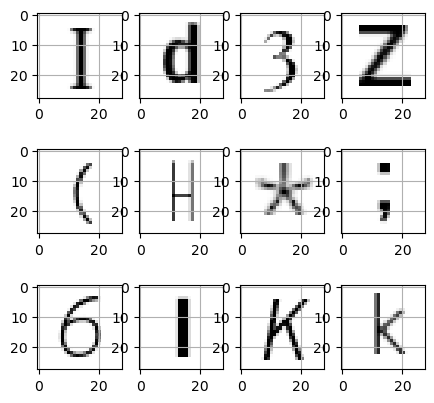

In [13]:
# Displaying some random characters from the dataset
shuffled_indices = np.random.permutation(X_train[:500].shape[0])[:12]
random_samples = X_train.iloc[shuffled_indices, :]

fig, axes = plt.subplots(3, 4, figsize=(5, 5))
axes = axes.flatten()

for idx, img_data in enumerate(random_samples.values):
    img = np.reshape(img_data, (28, 28))
    axes[idx].imshow(img, cmap="Greys")
    axes[idx].grid()

plt.show()

Here, we can see some sample characters from our dataset.

# Importing the required Libraries for building the neural network

In [14]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Building the CNN Architecture

![AN example of CNN](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*5A4b1qOZIr4Q6SKceqGn7w.jpeg)

In [15]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=(img_width, img_height, num_channels)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(350, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In this code, we are building a neural network model that can identify handwritten characters. The model consists of several layers of mathematical operations, each of which extracts and transforms the features of the image. The first layer is a convolutional layer, which applies filters to the image to identify important patterns. The subsequent layers further extract the features of the image, compress the information, and then output a prediction. We use the softmax activation function to produce the final prediction probabilities for each possible class of characters. The model is trained on a dataset of labeled images and the accuracy of the model is evaluated on a separate test set.

In [18]:
# Compile the model
optimizer = Adam(learning_rate=0.01)
callback = EarlyStopping(monitor='loss', patience=5)
batch_size = 64
epochs = 100
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Training the Model

In [19]:
# Training
history = model.fit(X_train_reshaped, y_train_one_hot, validation_data=(X_test_reshaped, y_test_one_hot), batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100


2023-04-16 22:36:17.359790: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2998/2998 [==============================] - 37s 9ms/step - loss: 0.6315 - accuracy: 0.8177 - val_loss: 0.3021 - val_accuracy: 0.9101
Epoch 2/100
2998/2998 [==============================] - 25s 8ms/step - loss: 0.3837 - accuracy: 0.8821 - val_loss: 0.3112 - val_accuracy: 0.8975
Epoch 3/100
2998/2998 [==============================] - 26s 9ms/step - loss: 0.3484 - accuracy: 0.8930 - val_loss: 0.2673 - val_accuracy: 0.9124
Epoch 4/100
2998/2998 [==============================] - 24s 8ms/step - loss: 0.3248 - accuracy: 0.8985 - val_loss: 0.2570 - val_accuracy: 0.9168
Epoch 5/100
2998/2998 [==============================] - 26s 9ms/step - loss: 0.3089 - accuracy: 0.9042 - val_loss: 0.2546 - val_accuracy: 0.9232
Epoch 6/100
2998/2998 [==============================] - 25s 8ms/step - loss: 0.2955 - accuracy: 0.9082 - val_loss: 0.2482 - val_accuracy: 0.9208
Epoch 7/100
2998/2998 [==============================] - 25s 8ms/step - loss: 0.2880 - accuracy: 0.9104 - val_loss: 0.2242 - val_accurac

In this code, we are training our model by fitting it to our training data (X_train_reshaped) and the corresponding target labels (y_train_one_hot). We also provide our model with validation data (X_test_reshaped and y_test_one_hot) so that we can evaluate the performance of our model during training. We are specifying the batch size and number of epochs for the training process, and the verbose parameter is set to 1 so that we can see the progress of the training process during each epoch.

# Evaluating the model

In [31]:
# Evaluating model accuracy on test data
score = model.evaluate(X_test_reshaped, y_test_one_hot, batch_size=batch_size, verbose=0)
print(f"Final Accuracy: {round(score[1], 4)*100}%")

Final Accuracy: 93.85%


The final accuracy of the model after training came out to be 93.85.

# Visualizing the Model's Performance

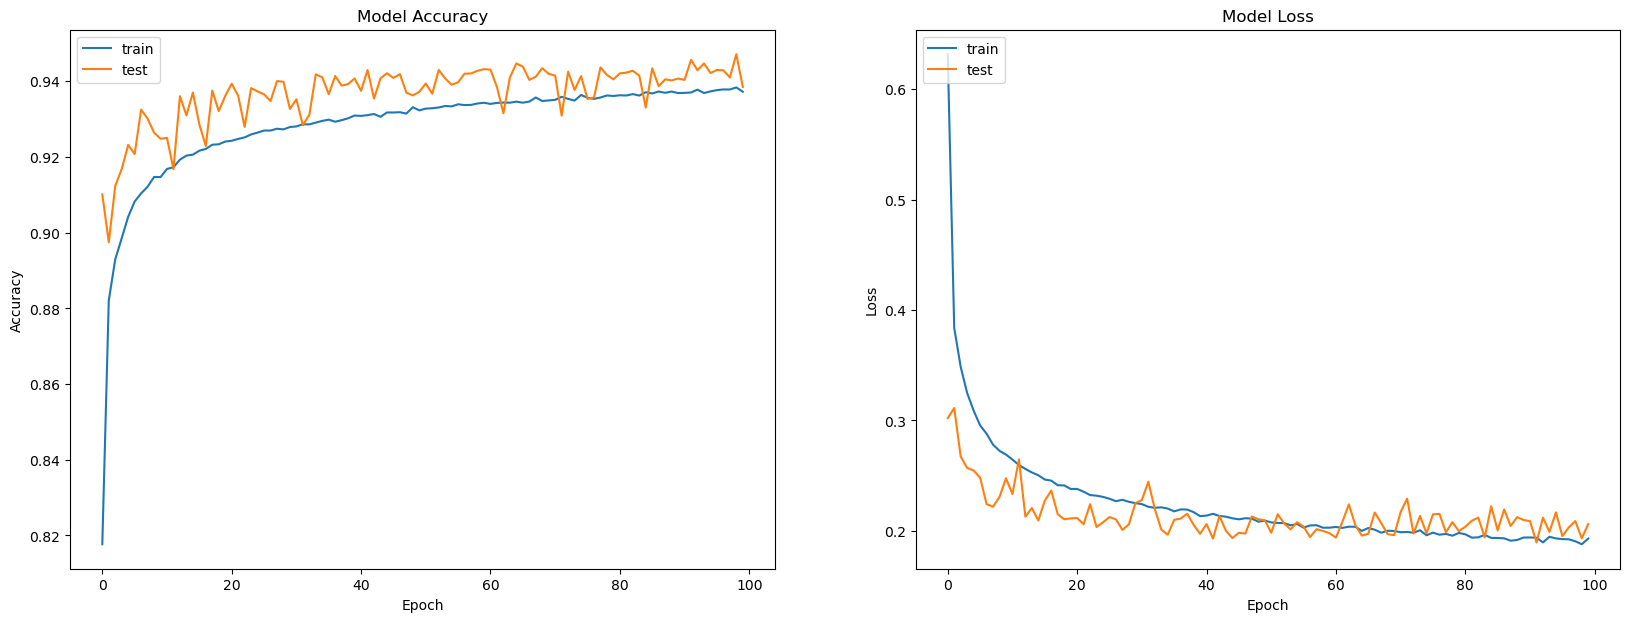

In [36]:
# Plot accuracy history
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'test'], loc='upper left')

# Plot loss history
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'test'], loc='upper left')

plt.show()

The accuracy plot shows the accuracy of the model on both the training and test data as the number of training epochs increases. The loss plot shows how much the model's predicted values deviate from the actual values during training and testing as the number of epochs increases. By plotting these metrics, we can evaluate the performance of the model and identify if there are any overfitting or underfitting issues.

# Making Final Predictions

1/1 [==============================] - 0s 23ms/step


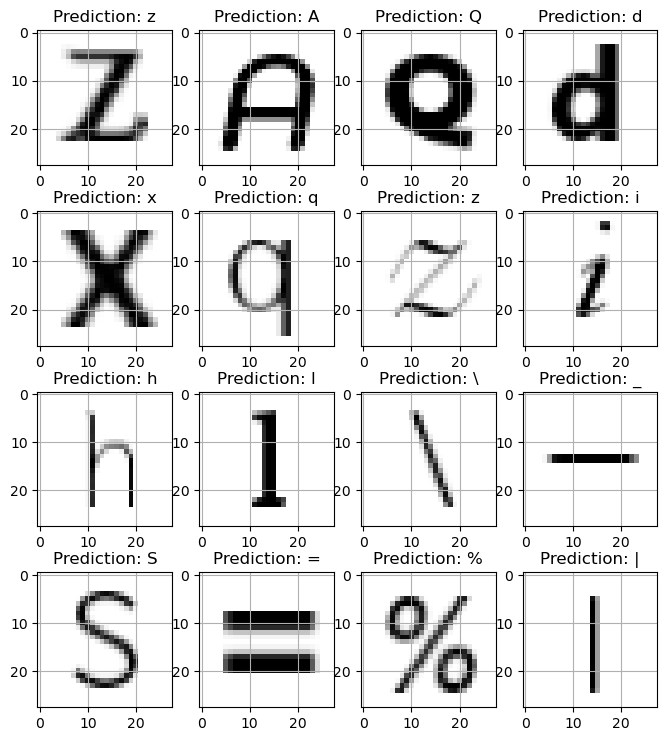

In [28]:
# Predicting the characters using trained model
fig, axes = plt.subplots(4, 4, figsize=(8, 9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = X_test.values[i].reshape(28, 28) # Reshape the image for displaying
    ax.imshow(img, cmap="Greys")
    img_final = img.reshape(1, 28, 28, 1) # Reshape the image for passing into model for prediction
    pred = value_to_label[np.argmax(model.predict(img_final))]
    ax.set_title("Prediction: " + pred)
    ax.grid()

As we can see here, our model is making predictions with 100% accuracy, which is great.

# Conclusion

1. The model performed very good and was predicted with a 100% accuracy, which was in our case, 16 out of 16 images.
2. The final accuracy of our model is 93.85%, which is okay.

# References

1. https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d
2. https://www.kaggle.com/code/sheshngupta/tminst-character-recognition-94-4-accuracy

# License

All code in this note is available as open source through the MIT license.

All text and images are free to use under the Creative Commons Attribution 3.0 license. https://creativecommons.org/licenses/by/3.0/us/

These licenses let others distribute, remix, tweak, and build upon the work, even commercially, as long as they give credit for the original creation.

Copyright(c) 2023 Kumar Mehul

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.